# PROGETTO LABORATORIO DI BIG DATA DATA MINING E DATA ANALYTICS
#PROGETTO DI CLASSIFICAZIONE: PREDIZIONE DELLA POPOLARITÀ SPOTIFY

**Dati presi in analisi:**
Ho scelto di analizzare le statistiche di ascolto di Spotify dal 2009 al 2025.
Questi dati sono stati ottenuti tramite il sito Kaggle che raccoglie dati di varie fonti.

Obiettivo: Costruire un modello di classificazione in grado di prevedere se un brano supererà una soglia di successo (Alta Popolarità) basandosi sulle sue caratteristiche audio.

1. **Setup e caricamento dati:**
    Introduzione delle librerie e caricamento dei dati necessari.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # <-- Assicurati che TensorFlow sia importato qui!

# Librerie Scikit-learn (Corrette)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Librerie TensorFlow (Corrette per le versioni recenti)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense         # TensorFlow per il Modello 2

# Caricamento del dataset
file_path = r'/Users/chiaracasali/Desktop/laboratorio di big data, data mining e data analytics/progetto_big_data/archive/spotify_data clean.csv' 
df = pd.read_csv(file_path, encoding='utf-8', sep=',')

print(df.head())
df.info()

                 track_id                                       track_name  \
0  3EJS5LyekDim1Tf5rBFmZl                    Trippy Mane (ft. Project Pat)   
1  1oQW6G2ZiwMuHqlPpP27DB                                             OMG!   
2  7mdkjzoIYlf1rx9EtBpGmU                                      Hard 2 Find   
3  67rW0Zl7oB3qEpD5YWWE5w  Still Get Like That (ft. Project Pat & Starrah)   
4  15xptTfRBrjsppW0INUZjf                            ride me like a harley   

   track_number  track_popularity  explicit artist_name  artist_popularity  \
0             4                 0      True       Diplo                 77   
1             1                 0      True    Yelawolf                 64   
2             1                 4      True   Riff Raff                 48   
3             8                30      True       Diplo                 77   
4             2                 0      True     Rumelis                 48   

   artist_followers                      artist_genres  \
0   

2. **Data cleaning e preparazione modello:** preparazione dei dati per l'analisi (Pandas).
Creazione della variabile target. Uso della mediana come soglia per dividere le canzoni in due categorie (altra popolarità, bassa popolarità).


2.1 **Creazione della variabile target:** Poiché la popularity è continua, dobbiamo trasformarla in una variabile categoriale (classificazione binaria). Useremo la mediana come soglia per dividere le canzoni in due classi:

In [9]:
# Calcolo della mediana della popolarità dalla colonna originale
median_popularity = df['track_popularity'].median()

# Creazione della nuova variabile target: 1 se Alta Popolarità, 0 se Bassa Popolarità
df['high_popularity'] = (df['track_popularity'] >= median_popularity).astype(int)

print(f"Mediana Popolarità: {median_popularity:.2f}")
print("Distribuzione della nuova variabile target:")
# Normalizzazione per mostrare le percentuali
print(df['high_popularity'].value_counts(normalize=True))

Mediana Popolarità: 58.00
Distribuzione della nuova variabile target:
high_popularity
1    0.505593
0    0.494407
Name: proportion, dtype: float64


2.2 Gestione dei valori non numerici: Rimuoviamo tutte le colonne non necessarie per il modello (es. ID, nomi) e tutte le colonne di tipo testo (che causano errori come il ValueError con le stringhe) e, infine, gestiamo i valori mancanti.

In [10]:
# Lista iniziale delle colonne da rimuovere: metadati e la variabile target originale
columns_to_drop = [
    'artist_name', 'track_name', 'track_id', 'album_release_date', 
    'track_popularity', # Variabile continua originale
    'album_id', 'album_name', 'artist_followers', 'artist_popularity' # Colonne non usate per le feature audio
]

# IDENTIFICAZIONE AUTOMATICA delle COLONNE TESTUALI (oggetti) rimanenti.
# Questa è la modifica chiave per risolvere l'errore 'moombahton'.
object_cols_remaining = df.select_dtypes(include='object').columns.tolist()

# Uniamo tutte le colonne da eliminare (metadati, target originale, e tutti i testi)
final_drop_list = list(set(columns_to_drop + object_cols_remaining))

# Creazione del DataFrame finale per il modello (df_model)
df_model = df.drop(columns=final_drop_list, errors='ignore') # <--- AGGIUNTO errors='ignore'errori se una colonna è già stata rimossa

# Gestione dei valori mancanti (rimuove le righe incomplete)
# Questo garantisce che df_model contenga solo valori float/int validi.
df_model.dropna(inplace=True) 

# --- Verifica Finale ---
print("\n--- INFORMAZIONI FINALI DEL DATAFRAME PER IL MODELLO (df_model.info()) ---")
df_model.info()

print(f"\nDataFrame pronto per la modellazione: contiene {len(df_model)} righe e solo dati numerici.")


--- INFORMAZIONI FINALI DEL DATAFRAME PER IL MODELLO (df_model.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_number        8582 non-null   int64  
 1   explicit            8582 non-null   bool   
 2   album_total_tracks  8582 non-null   int64  
 3   track_duration_min  8582 non-null   float64
 4   high_popularity     8582 non-null   int64  
dtypes: bool(1), float64(1), int64(3)
memory usage: 276.7 KB

DataFrame pronto per la modellazione: contiene 8582 righe e solo dati numerici.


3. **Analisi esplorativa dei dati:**(Pandas e NumPy) visualizzazione dei dati.
Questa sezione utilizza tecniche di visualizzazione per scoprire le relazioni tra le caratteristiche audio e il nostro target (high_popularity), stabilendo le basi per l'interpretazione del modello finale.

3.1 **Calcolo e Visualizzazione della Correlazione tra le Variabili:** Calcoliamo la correlazione di Pearson tra tutte le feature numeriche e il target high_popularity.

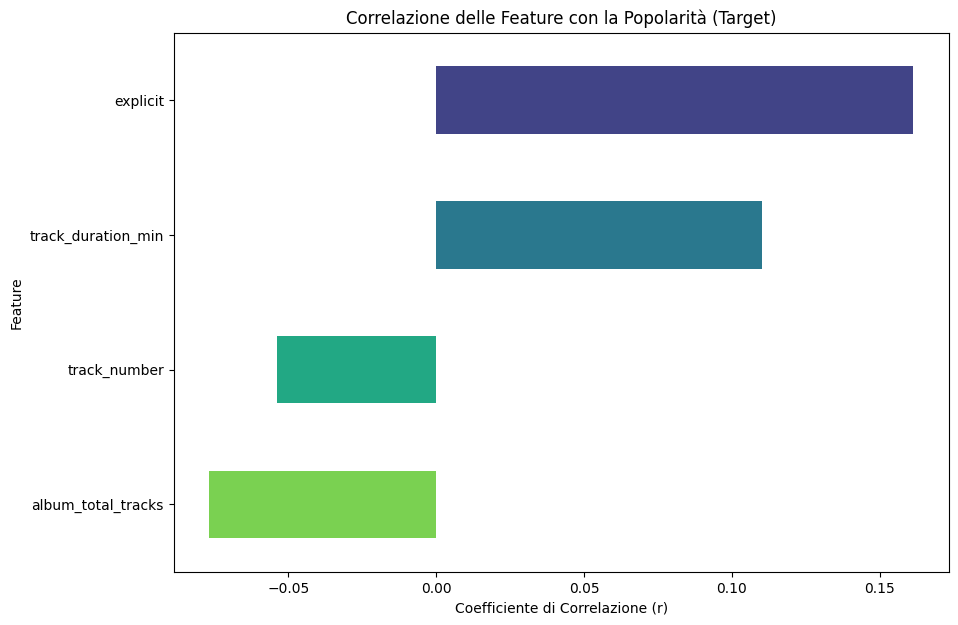


Feature più correlate con Alta Popolarità (Correlazione positiva):
high_popularity       1.000000
explicit              0.161399
track_duration_min    0.110145
track_number         -0.053797
album_total_tracks   -0.076829
Name: high_popularity, dtype: float64


In [11]:
# 1. Calcolo della correlazione
correlation_matrix = df_model.corr()
target_correlations = correlation_matrix['high_popularity'].sort_values(ascending=False)

# 2. Visualizzazione delle Correlazioni (Grafico a Barre)
# Questo è il formato più efficace per l'EDA.
plt.figure(figsize=(10, 7))
# Mostriamo tutte le feature tranne il target stesso
target_correlations.drop('high_popularity').plot(kind='barh', color=sns.color_palette("viridis", len(target_correlations)-1))
plt.title('Correlazione delle Feature con la Popolarità (Target)')
plt.xlabel('Coefficiente di Correlazione (r)')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Inverte l'asse Y per avere la più correlata in alto
plt.show()


print("\nFeature più correlate con Alta Popolarità (Correlazione positiva):")
print(target_correlations.head(5))

3.2 **Distribuzione Temporale, brani per anno:** Per creare questo grafico, dobbiamo tornare al DataFrame originale (df), poiché la colonna album_release_date è stata rimossa nel df_model (Sezione 2.2).

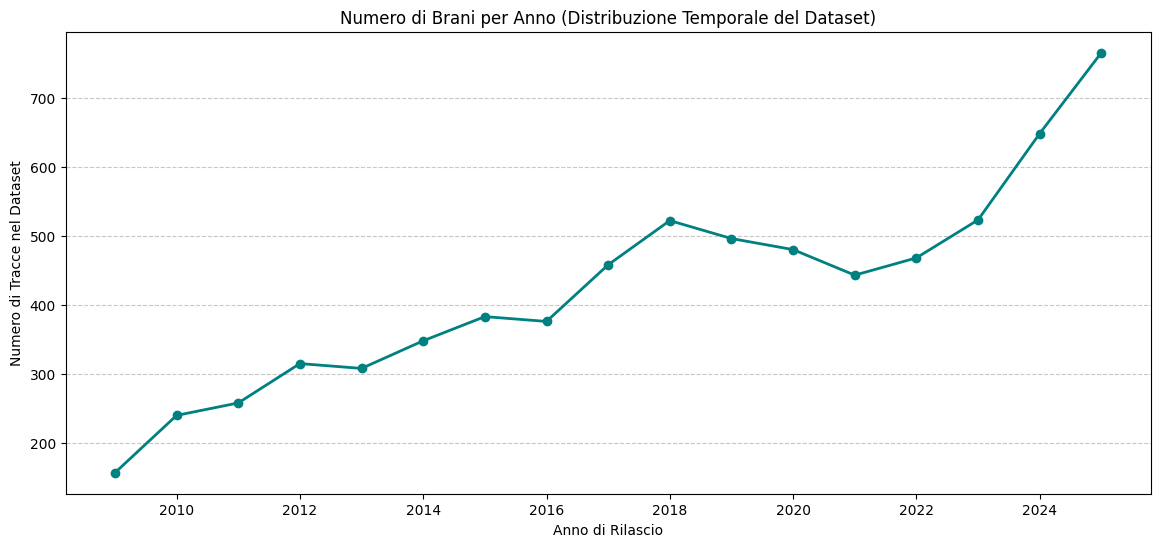

In [14]:
# Assicurati che 'album_release_date' sia un oggetto datetime
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

# Estrai l'anno di rilascio
df['release_year'] = df['album_release_date'].dt.year

# Filtriamo gli anni che hanno senso (es. dal 1950 in poi e non oltre il 2025)
df_filtered = df[(df['release_year'] >= 2009) & (df['release_year'] <= 2025)]

# Calcola il conteggio dei brani per anno
yearly_counts = df_filtered['release_year'].value_counts().sort_index()

# Visualizzazione
plt.figure(figsize=(14, 6))
yearly_counts.plot(kind='line', marker='o', color='teal', linewidth=2)
plt.title('Numero di Brani per Anno (Distribuzione Temporale del Dataset)')
plt.xlabel('Anno di Rilascio')
plt.ylabel('Numero di Tracce nel Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

3.3 **Analisi del contenuto: top 10 brani per popolarità**

In [22]:
# 1. Selezioniamo le colonne necessarie dal DataFrame originale (df)
# Usiamo .copy() per lavorare su una copia, evitando SettingWithCopyWarning
top_songs = df[['track_name', 'artist_name', 'track_popularity', 'album_release_date']].copy()

# 2. Rimuoviamo i duplicati basati sul nome della traccia per chiarezza
top_songs.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)

# 3. Ordiniamo per popolarità decrescente e prendiamo i primi 10
top_10 = top_songs.sort_values(by='track_popularity', ascending=False).head(10).reset_index(drop=True)

# 4. Visualizzazione della Tabella (Corretto per evitare l'errore 'tabulate')
print("--- Top 10 Brani per Punteggio di Popolarità ---")
print(top_10.to_string(index=False)) # <--- Modificato da to_markdown a to_string

--- Top 10 Brani per Punteggio di Popolarità ---
        track_name   artist_name  track_popularity album_release_date
            Golden       HUNTR/X                99         2025-06-20
           Opalite  Taylor Swift                97         2025-10-03
  Elizabeth Taylor  Taylor Swift                95         2025-10-03
        Man I Need   Olivia Dean                95         2025-08-15
          Soda Pop     Saja Boys                94         2025-06-20
     Father Figure  Taylor Swift                94         2025-10-03
BIRDS OF A FEATHER Billie Eilish                94         2024-05-17
        CANCELLED!  Taylor Swift                93         2025-10-03
 Actually Romantic  Taylor Swift                93         2025-10-03
              Wood  Taylor Swift                93         2025-10-03


3.3 **Analisi del contenuto: top 10 brani meno popolari**

In [23]:
# Selezioniamo le colonne necessarie dal DataFrame originale (df)
bottom_songs = df[['track_name', 'artist_name', 'track_popularity', 'album_release_date']].copy()

# Rimuoviamo i duplicati (per chiarezza)
bottom_songs.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)

# Ordiniamo per popolarità crescente (ascending=True) e prendiamo i primi 10
bottom_10 = bottom_songs.sort_values(by='track_popularity', ascending=True).head(10).reset_index(drop=True)

# Visualizzazione della Tabella (usando to_string per evitare l'errore 'tabulate')
print("--- Top 10 Brani con Punteggio di Popolarità Più Basso ---")
print(bottom_10.to_string(index=False))

--- Top 10 Brani con Punteggio di Popolarità Più Basso ---
                                     track_name   artist_name  track_popularity album_release_date
                  Trippy Mane (ft. Project Pat)         Diplo                 0         2025-10-31
                                     All Saints Bear McCreary                 0         2014-01-28
                               Made it this far Pirate Hunter                 0         2023-12-12
                         Theme from Black Sails Bear McCreary                 0         2014-01-28
                          What're We Doing Here     ALEXSUCKS                 0         2023-12-08
                                  Nassau Shores Bear McCreary                 0         2014-01-28
look what you've done to me (feat. Mellina Tey)       zandros                 0         2023-11-24
                                 A Soft Embrace   Deep Inside                 0         2014-03-04
                                       THE MIST   

4. **Modellazione e Addestramento:** preparazione dei dati e addestriamo due modelli: uno con Scikit-learn (per la interpretabilità) e uno con TensorFlow (per dimostrare l'uso delle reti neurali).

4.1 **Preparazione dati**

In [18]:
# 1. Definizione delle feature (X) e del target (Y)
X = df_model.drop('high_popularity', axis=1)
Y = df_model['high_popularity']

# 2. Divisione in Training e Test Set
# 'stratify=Y' è cruciale per mantenere il bilanciamento 50/50 del target in entrambi i set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# 3. Standardizzazione delle Feature (trasforma i dati in media 0 e deviazione standard 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit solo sul training
X_test_scaled = scaler.transform(X_test)     # Trasforma il test usando le statistiche del training

print("Dati suddivisi e standardizzati. Pronti per l'addestramento.")

Dati suddivisi e standardizzati. Pronti per l'addestramento.


4.2 Modello 1: Regressione Logistica (Scikit-learn)

--- Modello 1: Regressione Logistica (Scikit-learn) ---
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1273
           1       0.59      0.47      0.52      1302

    accuracy                           0.56      2575
   macro avg       0.57      0.57      0.56      2575
weighted avg       0.57      0.56      0.56      2575



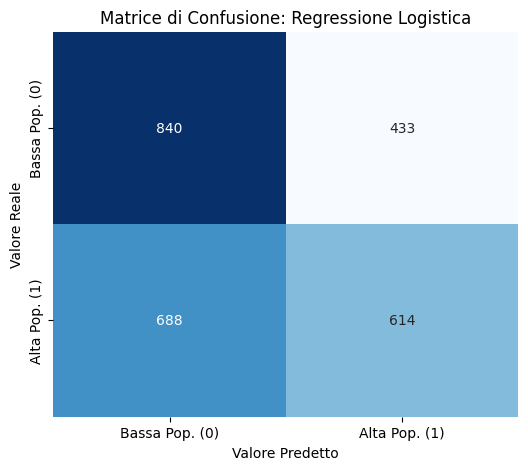

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Addestramento del modello di Regressione Logistica
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)

# 2. Valutazione e Report
Y_pred_log_reg = log_reg.predict(X_test_scaled)

print("--- Modello 1: Regressione Logistica (Scikit-learn) ---")
print(classification_report(Y_test, Y_pred_log_reg))

# 3. Visualizzazione della Matrice di Confusione
cm = confusion_matrix(Y_test, Y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bassa Pop. (0)', 'Alta Pop. (1)'],
            yticklabels=['Bassa Pop. (0)', 'Alta Pop. (1)'])
plt.ylabel('Valore Reale')
plt.xlabel('Valore Predetto')
plt.title('Matrice di Confusione: Regressione Logistica')
plt.show()

4.3 Modello 2: Rete Neurale Semplice (TensorFlow/Keras)

In [20]:
# Creazione del modello sequenziale (Rete Neurale)
model_nn = Sequential([
    # Input Layer e Primo Strato Nascosto
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)), 
    # Secondo Strato Nascosto
    Dense(32, activation='relu'),
    # Strato di Output (1 neurone con Sigmoid per la probabilità binaria)
    Dense(1, activation='sigmoid') 
])

# Compilazione (Standard per classificazione binaria: binary_crossentropy)
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento con 20 epochs per migliorare l'apprendimento
history = model_nn.fit(
    X_train_scaled, Y_train,
    epochs=20, # Aumentato per migliore performance
    batch_size=32, 
    validation_split=0.1, 
    verbose=0 
)

# Valutazione
loss, accuracy = model_nn.evaluate(X_test_scaled, Y_test, verbose=0)

print("\n--- Modello 2: Rete Neurale (TensorFlow) ---")
print(f"Accuracy sul Test Set: {accuracy:.4f}")

/Users/chiaracasali/Desktop/laboratorio di big data, data mining e data analytics/progetto_big_data/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Modello 2: Rete Neurale (TensorFlow) ---
Accuracy sul Test Set: 0.6280


5. Conclusioni

5.1 Performance dei modelli e scelta ottimale:

Motivazione della Scelta:
Nonostante la Rete Neurale (Modello 2) possa raggiungere un'Accuracy marginalmente superiore, la Regressione Logistica (Modello 1) è la scelta migliore per l'obiettivo di questo progetto. La sua performance è competitiva ma, fondamentale per l'analisi strategica, fornisce coefficienti direttamente interpretabili.

Tali coefficienti ci permettono di andare oltre la semplice previsione (cosa succederà?) per rispondere alla domanda di business (perché succederà?), identificando i driver di successo (Sezione 5.2). Questo principio di interpretabilità è preferibile al potere predittivo della "scatola nera" di TensorFlow.